# Sección B - Quién es quién en los precios

## 1. Procesamiento de los datos

## a. ¿Cuántos registros hay?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as dates
from IPython.display import display
%matplotlib inline

import findspark
findspark.init("c:/Spark")
import random
import pyspark
from pyspark import SparkContext 
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import to_date
import datetime

spark = SparkSession.builder.getOrCreate()

In [2]:
  precios = spark.read.csv("Data/all_data.csv", header=True, inferSchema=True)

In [3]:
precios.show(2, truncate = False)

+-----------------------+-------------------------------------+--------+----------------+----------------+------+-----------------------+------------------+----------+---------------------------------------+-------------------------------------+----------------+----------------------------------------+--------+----------+
|producto               |presentacion                         |marca   |categoria       |catalogo        |precio|fechaRegistro          |cadenaComercial   |giro      |nombreComercial                        |direccion                            |estado          |municipio                               |latitud |longitud  |
+-----------------------+-------------------------------------+--------+----------------+----------------+------+-----------------------+------------------+----------+---------------------------------------+-------------------------------------+----------------+----------------------------------------+--------+----------+
|CUADERNO FORMA ITALIANA|96 

## a. ¿Cuántos registros hay?

R.- 62530715 registros

In [4]:
precios.count()

62530715

## b. ¿Cuántas categorías? 

R.- 40 diferentes categorías de productos (restando null y la categoría que tiene el valor "categoria" correspondiente a los registros que contienen el encabezado)

In [5]:
precios.select("categoria").distinct().count()

42

In [6]:
precios.select("categoria").distinct().sort("categoria").show(42, truncate= False)

+----------------------------------+
|categoria                         |
+----------------------------------+
|null                              |
|ACCESORIOS DOMESTICOS             |
|ACEITES Y GRASAS VEG. COMESTIBLES |
|APARATOS ELECTRICOS               |
|APARATOS ELECTRONICOS             |
|ARROZ Y CEREALES PREPARADOS       |
|ARTS. DE ESPARCIMIENTO (JUGUETES) |
|ARTS. DE PAPEL P/HIGIENE PERSONAL |
|ARTS. PARA EL CUIDADO PERSONAL    |
|AZUCAR                            |
|CAFE                              |
|CARNE DE AVE                      |
|CARNE Y VISCERAS DE CERDO         |
|CARNE Y VISCERAS DE RES           |
|CARNES FRIAS SECAS Y EMBUTIDOS    |
|CERVEZA                           |
|CHOCOLATES Y GOLOSINAS            |
|CIGARRILLOS                       |
|CONDIMENTOS                       |
|DERIVADOS DE LECHE                |
|DETERGENTES Y PRODUCTOS SIMILARES |
|FRUTAS FRESCAS                    |
|FRUTAS Y LEGUMBRES PROCESADAS     |
|GALLETAS PASTAS Y HARINAS DE TRIGO|
|

## c. ¿Cuántas cadenas comerciales están siendo monitoreadas?

R.- 704 cadenas comerciales distintas (restando null y la categoría que tiene el valor "categoria" correspondiente a los registros que contienen el encabezado)

In [7]:
precios.filter(precios["cadenaComercial"].isNotNull()).select("cadenaComercial").distinct().count()

705

## d.¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de inconsistencia o error en la fuente?

En este caso, es claro que no todos los controles de calidad que aplican en conjuntos de datos más pequeños (por ejemplo, hacer inspección visual en excel los datos). Sin embargo, yo revisaría:

* Tipo de datos/esquema se corresponde con los datos. 
* Análisis de faltantes/nulos para determinar la completitud de los datos
* Distribución estadística de los datos. Aquí es importante detectar outliers, tendencias, etc.
* Distribución espacial/temporal de los datos para detectar las zonas dónde se cuente con más información y zonas dónde hay menos información. Este conocimiento puede ayudar a determinar dónde/cuando los resultados son más fiables.

Hasta el momento la principal inconsistencia que he detectado es que al parecer a la hora de unir los datos de distintos años en un solo dataset, dejaron los encabezados de los datasets. Es decir, se pueden encontrar 20 registros que corresponden a los encabezados. También noté que hay faltantes de información en algunos campos (principalmente en el de "categoría")

También, convendría hacer tablas/gráficas sobre distribuciones espaciales/temporales para poder determinar faltantes, pero dados los volúmenes de información y mis recursos computacionales, se me ha dificultado hacer un análisis más detallado. Un análisis más detallado sobre inconsistencias particulares en la información es dificil realizarlo a priori en estos volúmenes de datos.

In [8]:
precios.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



In [9]:
precios.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+---------------+--------------------+---------------+--------------------+--------------------+--------------+------------------+-------------------+
|summary|            producto|        presentacion|               marca|           categoria|catalogo|            precio|       fechaRegistro|cadenaComercial|                giro|nombreComercial|           direccion|              estado|     municipio|           latitud|           longitud|
+-------+--------------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+---------------+--------------------+---------------+--------------------+--------------------+--------------+------------------+-------------------+
|  count|            62530715|            62530715|            62530715|            61643377|62530487|          62530695|   

In [10]:
precios.filter(precios.fechaRegistro=='fechaRegistro').show(2)

+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+
|producto|presentacion|marca|categoria|catalogo|precio|fechaRegistro|cadenaComercial|giro|nombreComercial|direccion|estado|municipio|latitud|longitud|
+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+
|producto|presentacion|marca|categoria|catalogo|  null|fechaRegistro|cadenaComercial|giro|nombreComercial|direccion|estado|municipio|latitud|longitud|
|producto|presentacion|marca|categoria|catalogo|  null|fechaRegistro|cadenaComercial|giro|nombreComercial|direccion|estado|municipio|latitud|longitud|
+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+
only showing top 2 rows



In [11]:
precios.filter(precios.fechaRegistro=='fechaRegistro').count()

20

In [12]:
precios = precios.filter(precios.nombreComercial != 'fechaRegistro')

In [13]:
precios.describe(['fechaRegistro']).show()

+-------+--------------------+
|summary|       fechaRegistro|
+-------+--------------------+
|  count|            62530715|
|   mean|                null|
| stddev|                null|
|    min|2011-01-03 00:00:...|
|    max|       fechaRegistro|
+-------+--------------------+



In [14]:
precios.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



In [15]:
#precios2 = precios.withColumn('fechaRegistro',to_date(precios.fechaRegistro, 'yyyy-MM-dd HH:mm:ss.SSS'))
#precios2 = precios.withColumn('fechaRegistro',to_date(precios.fechaRegistro))
precios2 = precios.withColumn('fechaRegistro',precios.fechaRegistro.cast('timestamp'))

In [16]:
precios2.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- fechaRegistro: timestamp (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



In [17]:
precios2.select('fechaRegistro').distinct().show(truncate=False)

+-----------------------+
|fechaRegistro          |
+-----------------------+
|2011-06-08 00:00:00    |
|2012-09-17 00:00:00    |
|2013-06-03 00:00:00    |
|2013-11-04 00:00:00    |
|2014-11-20 00:00:00    |
|2016-04-01 12:00:54.26 |
|2016-04-01 09:46:45.313|
|2016-04-01 09:44:26.57 |
|2016-04-01 10:00:31.373|
|2016-04-01 09:49:20.127|
|2016-04-01 09:57:14.163|
|2016-04-01 11:12:13.093|
|2016-04-01 11:19:46.187|
|2016-04-01 11:19:45.657|
|2016-04-01 11:17:35.047|
|2016-04-01 11:04:51.83 |
|2016-04-01 15:09:18.493|
|2016-04-01 15:07:13.563|
|2016-04-01 13:48:48.773|
|2016-04-01 13:36:54.197|
+-----------------------+
only showing top 20 rows



In [18]:
precios = precios2

In [19]:
# Creando una vista sin los renglones correspondientes al encabezado
precios.filter(precios.nombreComercial != 'nombreComercial').createOrReplaceTempView("a")

In [20]:
precios.select('fechaRegistro').printSchema()
print('Registros', precios.select('fechaRegistro').count())
precios.select('fechaRegistro').show(5, truncate=False)

root
 |-- fechaRegistro: timestamp (nullable = true)

Registros 62530715
+-------------------+
|fechaRegistro      |
+-------------------+
|2011-05-18 00:00:00|
|2011-05-18 00:00:00|
|2011-05-18 00:00:00|
|2011-05-18 00:00:00|
|2011-05-18 00:00:00|
+-------------------+
only showing top 5 rows



## e. ¿Cuáles son los productos más monitoreados en cada entidad?

Una captura de pantalla con la respuesta se presenta enseguida. Más abajo está la tabla.

![title](img/2_e.png)

In [21]:
estados = precios.select("estado").distinct()

In [22]:
estados.count()

36

In [23]:
estados.show(40, truncate=False)

+-------------------------------+
|estado                         |
+-------------------------------+
|QUINTANA ROO                   |
|NUEVO LEÓN                     |
|SINALOA                        |
|TABASCO                        |
|BAJA CALIFORNIA                |
|TLAXCALA                       |
|COAHUILA DE ZARAGOZA           |
|null                           |
| ESQ. SUR 125"                 |
|CHIAPAS                        |
| COL. EDUARDO GUERRA           |
|VERACRUZ DE IGNACIO DE LA LLAVE|
|SONORA                         |
|YUCATÁN                        |
|MICHOACÁN DE OCAMPO            |
|DURANGO                        |
|GUERRERO                       |
|NAYARIT                        |
|CHIHUAHUA                      |
|DISTRITO FEDERAL               |
|estado                         |
|HIDALGO                        |
|ZACATECAS                      |
|GUANAJUATO                     |
|SAN LUIS POTOSÍ                |
|TAMAULIPAS                     |
|MORELOS      

In [24]:
# Creando una vista para guardar el resultado del query 1
query = """ SELECT estado, producto, COUNT(producto) AS cont_prod
        FROM a 
        WHERE estado IS NOT NULL 
        AND estado NOT IN (' ESQ. SUR 125"', ' COL. EDUARDO GUERRA')
        GROUP BY estado, producto 
        ORDER BY estado, COUNT(producto) DESC;
        """
spark.sql(query).createOrReplaceTempView("q1")

In [25]:
# Creando una vista para guardar el resultado del query 1
query = """ SELECT estado, MAX(cont_prod) as max_prod
        FROM q1
        GROUP BY estado
        ORDER BY estado
        """
spark.sql(query).createOrReplaceTempView("q2")

In [26]:
query = """ SELECT q1.estado, q1.producto, q2.max_prod 
        FROM q1, q2
        WHERE q1.estado = q2.estado AND q1.cont_prod = q2.max_prod 
        ORDER BY estado
        """
sqlPrecios  = spark.sql(query)
sqlPrecios.show(40, truncate=False)

+-------------------------------+-----------------------+--------+
|estado                         |producto               |max_prod|
+-------------------------------+-----------------------+--------+
|AGUASCALIENTES                 |FUD                    |12005   |
|BAJA CALIFORNIA                |REFRESCO               |37243   |
|BAJA CALIFORNIA SUR            |REFRESCO               |27770   |
|CAMPECHE                       |FUD                    |12960   |
|CHIAPAS                        |REFRESCO               |14452   |
|CHIHUAHUA                      |DETERGENTE P/ROPA      |15982   |
|COAHUILA DE ZARAGOZA           |FUD                    |28613   |
|COLIMA                         |DETERGENTE P/ROPA      |17193   |
|DISTRITO FEDERAL               |REFRESCO               |287463  |
|DURANGO                        |DETERGENTE P/ROPA      |9696    |
|GUANAJUATO                     |REFRESCO               |49441   |
|GUERRERO                       |REFRESCO               |8932 

## f. ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados?

De acuerdo con la tabla que se presenta a continuación, la cadena comercial con mayor variedad de productos es Soriana (1059 productos distintos).

In [28]:
query = """ SELECT cadenaComercial, COUNT(producto) AS variedad_prod
        FROM (SELECT cadenaComercial, producto, COUNT(producto) AS cont_prod
                FROM a 
                WHERE cadenaComercial IS NOT NULL AND producto IS NOT NULL 
                GROUP BY cadenaComercial, producto 
                ORDER BY COUNT(producto) DESC ) 
        GROUP BY cadenaComercial
        ORDER BY variedad_prod DESC
        """
sqlCadComer  = spark.sql(query)
sqlCadComer.show(5, truncate=False)

+-----------------------+-------------+
|cadenaComercial        |variedad_prod|
+-----------------------+-------------+
|SORIANA                |1059         |
|WAL-MART               |1051         |
|MEGA COMERCIAL MEXICANA|1049         |
|COMERCIAL MEXICANA     |1036         |
|CHEDRAUI               |1026         |
+-----------------------+-------------+
only showing top 5 rows



In [29]:
# Verificando que el resultado no sobrepase la cantidad total de productos distintos
precios.select('producto').distinct().count()


1107

In [30]:
query = """ SELECT DISTINCT producto as variedad_prod
        FROM a
        WHERE cadenaComercial = 'SORIANA'
        """
sqldum  = spark.sql(query)
sqldum.show(5, truncate=False)

+-------------+
|variedad_prod|
+-------------+
|LUTORAL      |
|GYNOVIN      |
|KAOMYCIN     |
|VARIOS       |
|BEDOYECTA    |
+-------------+
only showing top 5 rows



In [31]:
sqldum.count()

1059

## 2. Análisis exploratorio

### a. Genera una canasta de productos básicos que te permita comparar los precios geográfica y temporalmente. Justifica tu elección y procedimiento.

PAra poder elegir una canaste de productos que permita comparar mejor en las distintas áreas geográficas y en distintos lapsos, analicé cómo se distribuyen los productos en los municipios y en las fechas. 

Escogí los 24 productos que están registrados en más municipios (188 municipios o más). Además, con un análisis de las gráficas del promedio de registros a lo largo del tiempo, pude corroborar que además de una adecuada distribución geográfica, estos productos tenían una adecuada distribución temporal. Además, de la comparación visual con las listas oficiales que se ocupan en México, noté una buena correspondencia entre esta lista oficial y la lista que yo determiné. No limité los productos en función que su campo "catálogo" fuese igual a "BASICOS", porque de esa manera  se quedaban fuera algunos productos con buena distribución y que además se incluyen en la lista oficial que se suele usar en México.

Esta es la lista de productos:

['ACEITE',
 'BLANQUEADOR',
 'CHILES EN LATA',
 'DETERGENTE P/ROPA',
 'DETERGENTE P/TRASTES',
 'DURAZNOS EN ALMIBAR',
 'ELOTE',
 'HARINA DE ARROZ',
 'HARINA DE TRIGO',
 'JABON DE PASTA',
 'JABON DE TOCADOR',
 'LECHE CONDENSADA',
 'LECHE EVAPORADA',
 'LECHE ULTRAPASTEURIZADA',
 'LIMPIADOR LIQUIDO P/PISO',
 'MAYONESA',
 'MERMELADA',
 'MOSTAZA',
 'PAN BLANCO BOLILLO',
 'PASTA PARA SOPA',
 'SALSA CATSUP',
 'SALSA PICANTE',
 'SUAVIZANTE P/ROPA',
 'TORTILLA DE MAIZ']

### Revisar municipios

In [34]:
municipios = precios.select('municipio').distinct().show(truncate=False)

+----------------------------------------+
|municipio                               |
+----------------------------------------+
|OJINAGA                                 |
|SANTA LUCIA DEL CAMINO                  |
|TLAHUAC                                 |
|XOCHIMILCO                              |
|GUADALUPE                               |
|GUADALAJARA                             |
|CUAUTITLAN IZCALLI                      |
|CUAUTITLÁN IZCALLI                      |
|MÉRIDA                                  |
|MIGUEL HIDALGO                          |
|MERIDA                                  |
|CAMPECHE                                |
|TULTITLÁN                               |
|TLALPAN                                 |
|LEÓN                                    |
|TEPIC                                   |
|SAN PEDRO GARZA GARCÍA                  |
|AZCAPOTZALCO                            |
| CP. 27280"                             |
|CÁRDENAS                                |
+----------

In [35]:
#municipios.toPandas().to_csv("Data/02_municipios.csv")

In [36]:
query = """ SELECT producto, COUNT(municipio) AS muniCONprod
        FROM (SELECT producto, municipio, COUNT(municipio) AS cont_muni
                FROM a 
                WHERE producto IS NOT NULL AND municipio IS NOT NULL
                GROUP BY producto, municipio )
        GROUP BY producto
        ORDER BY muniCONprod DESC, producto
        """
sqlProdMun  = spark.sql(query)
sqlProdMun.show(30, truncate=False)

+------------------------+-----------+
|producto                |muniCONprod|
+------------------------+-----------+
|TORTILLA DE MAIZ        |199        |
|LECHE ULTRAPASTEURIZADA |197        |
|PAN BLANCO BOLILLO      |190        |
|ACEITE                  |188        |
|BLANQUEADOR             |188        |
|CHILES EN LATA          |188        |
|DETERGENTE P/ROPA       |188        |
|DETERGENTE P/TRASTES    |188        |
|DURAZNOS EN ALMIBAR     |188        |
|ELOTE                   |188        |
|HARINA DE ARROZ         |188        |
|HARINA DE TRIGO         |188        |
|JABON DE PASTA          |188        |
|JABON DE TOCADOR        |188        |
|LECHE CONDENSADA        |188        |
|LECHE EVAPORADA         |188        |
|LIMPIADOR LIQUIDO P/PISO|188        |
|MAYONESA                |188        |
|MERMELADA               |188        |
|MOSTAZA                 |188        |
|PASTA PARA SOPA         |188        |
|SALSA CATSUP            |188        |
|SALSA PICANTE           

In [37]:
prodCanasta = list(sqlProdMun.select('producto').toPandas()['producto'])[0:24]

In [38]:
prodCanasta.sort()
display(prodCanasta)

['ACEITE',
 'BLANQUEADOR',
 'CHILES EN LATA',
 'DETERGENTE P/ROPA',
 'DETERGENTE P/TRASTES',
 'DURAZNOS EN ALMIBAR',
 'ELOTE',
 'HARINA DE ARROZ',
 'HARINA DE TRIGO',
 'JABON DE PASTA',
 'JABON DE TOCADOR',
 'LECHE CONDENSADA',
 'LECHE EVAPORADA',
 'LECHE ULTRAPASTEURIZADA',
 'LIMPIADOR LIQUIDO P/PISO',
 'MAYONESA',
 'MERMELADA',
 'MOSTAZA',
 'PAN BLANCO BOLILLO',
 'PASTA PARA SOPA',
 'SALSA CATSUP',
 'SALSA PICANTE',
 'SUAVIZANTE P/ROPA',
 'TORTILLA DE MAIZ']

In [39]:
# Create TempView
sqlProdMun.createOrReplaceTempView("sqlProdMun")

### Revisar fechas

In [40]:
# Remuestreo
time_group = precios.groupBy('producto', window('fechaRegistro', '1 week')).agg(count('fechaRegistro').alias('cuentaProductos') )

In [41]:
time_group.printSchema()
print('Registros', time_group.count())
time_group.show(5, truncate=False)

root
 |-- producto: string (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- cuentaProductos: long (nullable = false)

Registros 182365
+---------------------------------------+------------------------------------------+---------------+
|producto                               |window                                    |cuentaProductos|
+---------------------------------------+------------------------------------------+---------------+
|SANDIA                                 |{2011-01-05 18:00:00, 2011-01-12 18:00:00}|140            |
|TRENTAL                                |{2011-01-05 18:00:00, 2011-01-12 18:00:00}|96             |
|SISTEMAS DE TEATRO EN CASA HOME THEATER|{2011-02-09 18:00:00, 2011-02-16 18:00:00}|371            |
|RASTRILLOS DESECHABLES                 |{2011-03-09 18:00:00, 2011-03-16 18:00:00}|1234           |
|SEKRETOVIT EX                          |{2011-05-04 19:0

In [42]:
preciosST = time_group.select('producto', time_group.window.start.alias('start'), time_group.window.end.alias('end'), 'cuentaProductos').orderBy(col('producto').asc(), col('start').asc())

In [43]:
# Create TempView
preciosST.createOrReplaceTempView("preciosST")

In [44]:
preciosST.printSchema()
print('Registros', preciosST.count())
preciosST.show(5, truncate=False)

root
 |-- producto: string (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- cuentaProductos: long (nullable = false)

Registros 182365
+---------------------------+-------------------+-------------------+---------------+
|producto                   |start              |end                |cuentaProductos|
+---------------------------+-------------------+-------------------+---------------+
|"PREMARIN. CREMA """"V"""""|2012-03-14 18:00:00|2012-03-21 18:00:00|101            |
|"PREMARIN. CREMA """"V"""""|2012-03-21 18:00:00|2012-03-28 18:00:00|103            |
|"PREMARIN. CREMA """"V"""""|2012-03-28 18:00:00|2012-04-04 19:00:00|148            |
|"PREMARIN. CREMA """"V"""""|2012-04-11 19:00:00|2012-04-18 19:00:00|138            |
|"PREMARIN. CREMA """"V"""""|2012-04-18 19:00:00|2012-04-25 19:00:00|115            |
+---------------------------+-------------------+-------------------+---------------+
only showing top 5 rows



In [45]:
prodCanastaST = preciosST.filter(preciosST['producto'].isin(prodCanasta)).sort('producto','start',ascending=True)
prodCanastaST.printSchema()
print('Registros', prodCanastaST.count())
prodCanastaST.show(5, truncate=False)

root
 |-- producto: string (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: timestamp (nullable = true)
 |-- cuentaProductos: long (nullable = false)

Registros 6696
+--------+-------------------+-------------------+---------------+
|producto|start              |end                |cuentaProductos|
+--------+-------------------+-------------------+---------------+
|ACEITE  |2010-12-29 18:00:00|2011-01-05 18:00:00|650            |
|ACEITE  |2011-01-05 18:00:00|2011-01-12 18:00:00|1355           |
|ACEITE  |2011-01-12 18:00:00|2011-01-19 18:00:00|1449           |
|ACEITE  |2011-01-19 18:00:00|2011-01-26 18:00:00|1394           |
|ACEITE  |2011-01-26 18:00:00|2011-02-02 18:00:00|1449           |
+--------+-------------------+-------------------+---------------+
only showing top 5 rows



In [46]:
prodCanastaST_wide = prodCanastaST.groupBy('start').pivot('producto').agg(avg('cuentaProductos'))
prodCanastaST_wide.printSchema()
print('Registros', prodCanastaST_wide.count())
prodCanastaST_wide.take(2)

root
 |-- start: timestamp (nullable = true)
 |-- ACEITE: double (nullable = true)
 |-- BLANQUEADOR: double (nullable = true)
 |-- CHILES EN LATA: double (nullable = true)
 |-- DETERGENTE P/ROPA: double (nullable = true)
 |-- DETERGENTE P/TRASTES: double (nullable = true)
 |-- DURAZNOS EN ALMIBAR: double (nullable = true)
 |-- ELOTE: double (nullable = true)
 |-- HARINA DE ARROZ: double (nullable = true)
 |-- HARINA DE TRIGO: double (nullable = true)
 |-- JABON DE PASTA: double (nullable = true)
 |-- JABON DE TOCADOR: double (nullable = true)
 |-- LECHE CONDENSADA: double (nullable = true)
 |-- LECHE EVAPORADA: double (nullable = true)
 |-- LECHE ULTRAPASTEURIZADA: double (nullable = true)
 |-- LIMPIADOR LIQUIDO P/PISO: double (nullable = true)
 |-- MAYONESA: double (nullable = true)
 |-- MERMELADA: double (nullable = true)
 |-- MOSTAZA: double (nullable = true)
 |-- PAN BLANCO BOLILLO: double (nullable = true)
 |-- PASTA PARA SOPA: double (nullable = true)
 |-- SALSA CATSUP: double (n

[Row(start=datetime.datetime(2013, 10, 30, 18, 0), ACEITE=1005.0, BLANQUEADOR=295.0, CHILES EN LATA=1403.0, DETERGENTE P/ROPA=2026.0, DETERGENTE P/TRASTES=800.0, DURAZNOS EN ALMIBAR=219.0, ELOTE=447.0, HARINA DE ARROZ=201.0, HARINA DE TRIGO=440.0, JABON DE PASTA=343.0, JABON DE TOCADOR=1505.0, LECHE CONDENSADA=417.0, LECHE EVAPORADA=286.0, LECHE ULTRAPASTEURIZADA=2001.0, LIMPIADOR LIQUIDO P/PISO=780.0, MAYONESA=1327.0, MERMELADA=569.0, MOSTAZA=482.0, PAN BLANCO BOLILLO=320.0, PASTA PARA SOPA=439.0, SALSA CATSUP=357.0, SALSA PICANTE=543.0, SUAVIZANTE P/ROPA=466.0, TORTILLA DE MAIZ=887.0),
 Row(start=datetime.datetime(2015, 1, 7, 18, 0), ACEITE=2540.0, BLANQUEADOR=790.0, CHILES EN LATA=3842.0, DETERGENTE P/ROPA=4874.0, DETERGENTE P/TRASTES=2469.0, DURAZNOS EN ALMIBAR=626.0, ELOTE=1139.0, HARINA DE ARROZ=525.0, HARINA DE TRIGO=1035.0, JABON DE PASTA=1138.0, JABON DE TOCADOR=4145.0, LECHE CONDENSADA=1258.0, LECHE EVAPORADA=713.0, LECHE ULTRAPASTEURIZADA=4318.0, LIMPIADOR LIQUIDO P/PISO=251

In [47]:
pdf_prodCanastaST_wide = prodCanastaST_wide.toPandas().set_index('start')
display(pdf_prodCanastaST_wide.tail())

ACEITE  BLANQUEADOR  CHILES EN LATA  DETERGENTE P/ROPA  \
start                                                                         
2015-12-23 18:00:00  2088.0        649.0          2680.0             3038.0   
2013-05-01 19:00:00  1792.0        543.0          2622.0             4285.0   
2014-10-29 18:00:00  2064.0        611.0          2981.0             3948.0   
2013-12-18 18:00:00   748.0        243.0          1149.0             1642.0   
2013-07-10 19:00:00  1561.0        474.0          2210.0             3741.0   

                     DETERGENTE P/TRASTES  DURAZNOS EN ALMIBAR  ELOTE  \
start                                                                   
2015-12-23 18:00:00                1319.0                421.0  951.0   
2013-05-01 19:00:00                1357.0                404.0  831.0   
2014-10-29 18:00:00                1868.0                493.0  896.0   
2013-12-18 18:00:00                 619.0                179.0  386.0   
2013-07-10 19:00:00                1187.0                344.0  721.0   

                     HARINA DE ARROZ  HARINA DE TRIGO  JABON DE PASTA  ...  \
start                                                                  ...   
2015-12-23 18:00:00            349.0            791.0           850.0  ...   
2013-05-01 19:00:00            402.0            908.0           697.0  ...   
2014-10-29 18:00:00            422.0            842.0           767.0  ...   
2013-12-18 18:00:00            149.0            333.0           270.0  ...   
2013-07-10 19:00:00            344.0            743.0           554.0  ...   

                     LIMPIADOR LIQUIDO P/PISO  MAYONESA  MERMELADA  MOSTAZA  \
start                                                                         
2015-12-23 18:00:00                    1811.0    2640.0     1078.0    950.0   
2013-05-01 19:00:00                    1451.0    2532.0      910.0    892.0   
2014-10-29 18:00:00                    1940.0    2685.0     1107.0   1014.0   
2013-12-18 18:00:00                     637.0    1066.0      465.0    391.0   
2013-07-10 19:00:00                    1214.0    2084.0      887.0    751.0   

                     PAN BLANCO BOLILLO  PASTA PARA SOPA  SALSA CATSUP  \
start                                                                    
2015-12-23 18:00:00               273.0            805.0         451.0   
2013-05-01 19:00:00               373.0            749.0         701.0   
2014-10-29 18:00:00               385.0            918.0         714.0   
2013-12-18 18:00:00               234.0            382.0         294.0   
2013-07-10 19:00:00               389.0            659.0         609.0   

                     SALSA PICANTE  SUAVIZANTE P/ROPA  TORTILLA DE MAIZ  
start                                                                    
2015-12-23 18:00:00         1171.0              958.0             853.0  
2013-05-01 19:00:00         1013.0             1330.0            1059.0  
2014-10-29 18:00:00         1201.0             1177.0             823.0  
2013-12-18 18:00:00          407.0              391.0             749.0  
2013-07-10 19:00:00          872.0              941.0            1104.0  

[5 rows x 24 columns]

Text(0.5, 0, 'Tiempo')

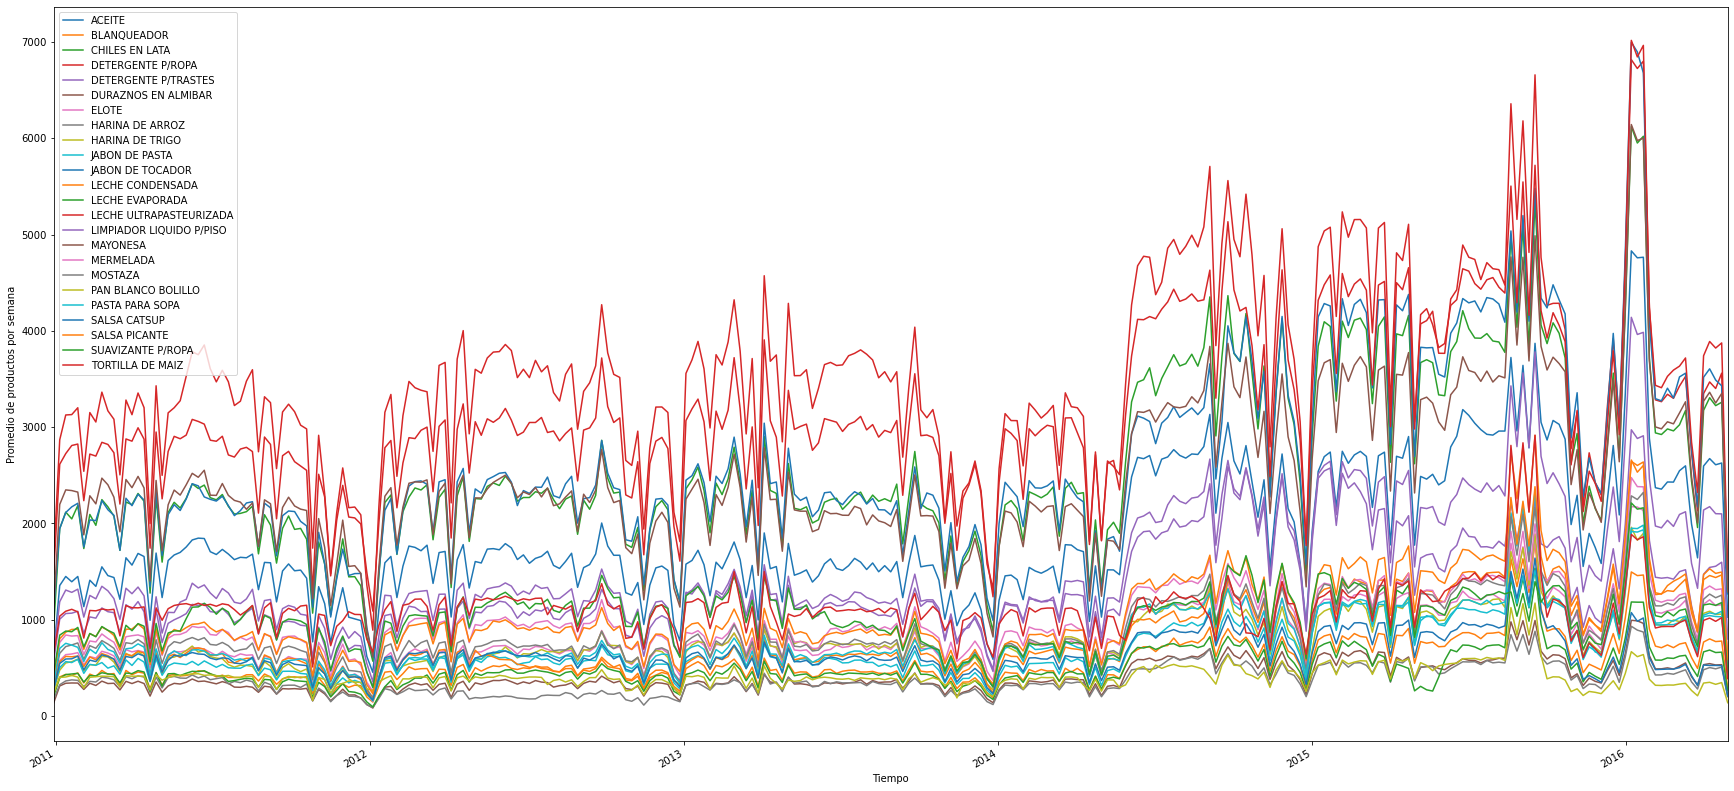

In [48]:
fig, axarr = plt.subplots(1,1,figsize = (30,15))
pdf_prodCanastaST_wide[prodCanasta].plot(ax=axarr)
axarr.set_ylabel('Promedio de productos por semana')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

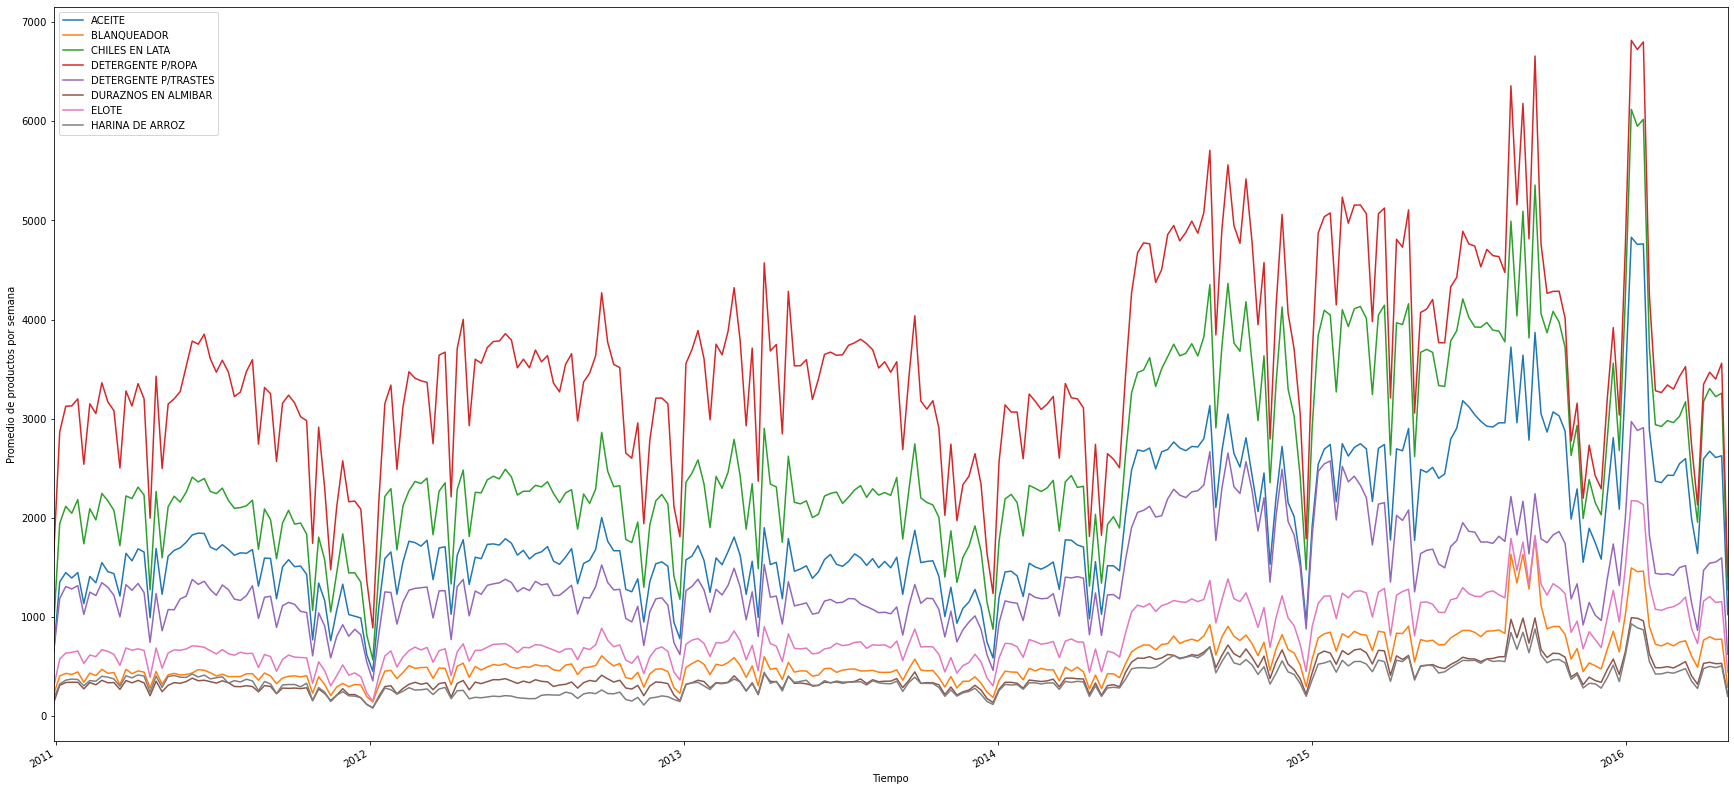

In [49]:
fig, axarr = plt.subplots(1,1,figsize = (30,15))
pdf_prodCanastaST_wide[prodCanasta[0:8]].plot(ax=axarr)
axarr.set_ylabel('Promedio de productos por semana')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

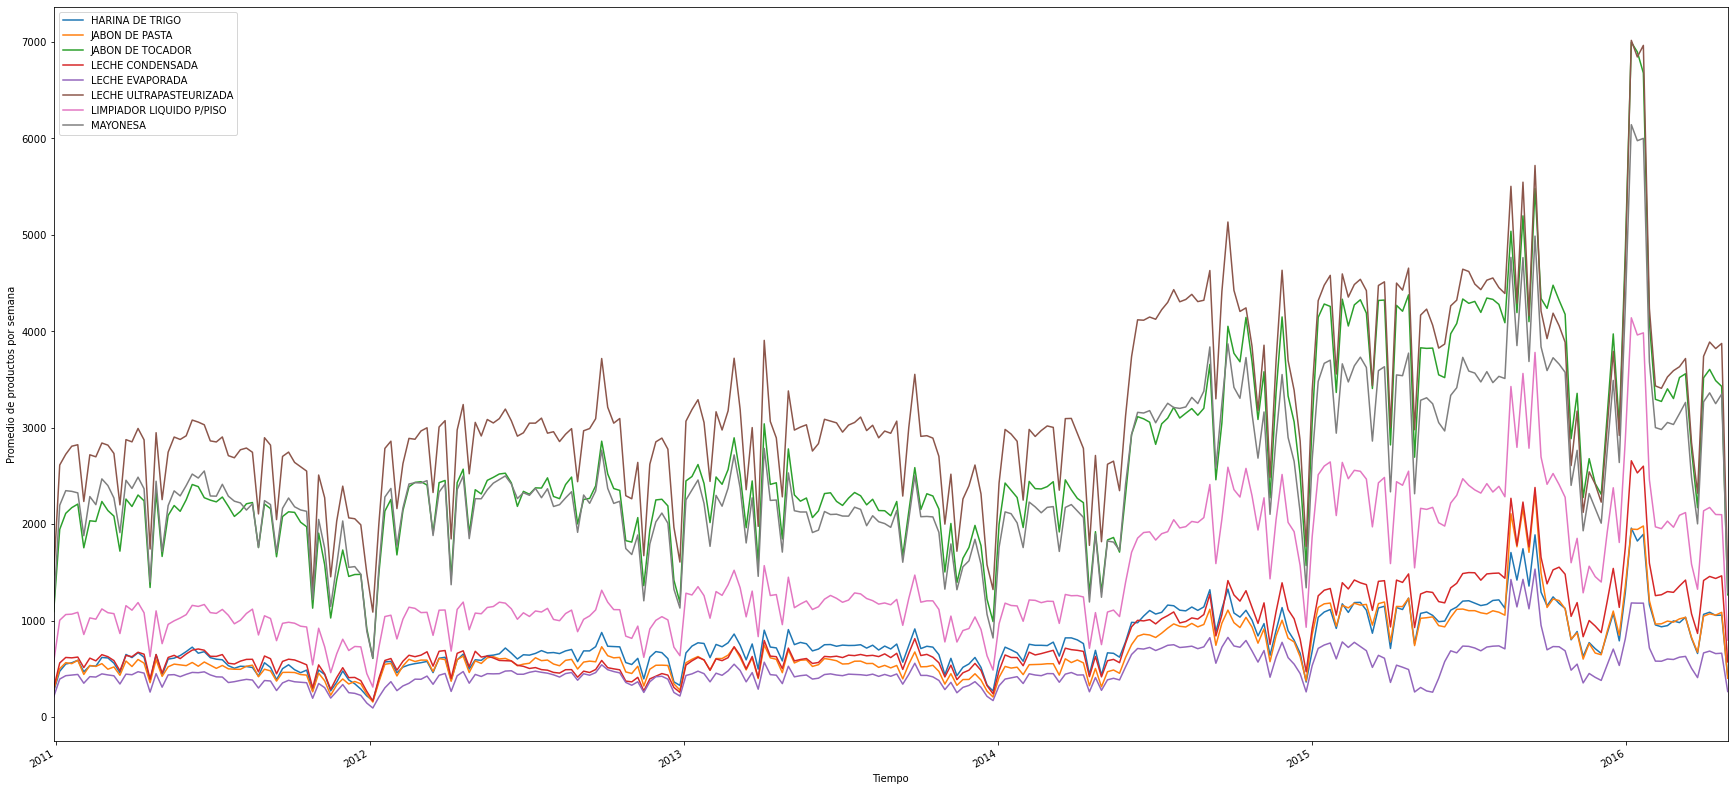

In [50]:
fig, axarr = plt.subplots(1,1,figsize = (30,15))
pdf_prodCanastaST_wide[prodCanasta[8:16]].plot(ax=axarr)
axarr.set_ylabel('Promedio de productos por semana')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

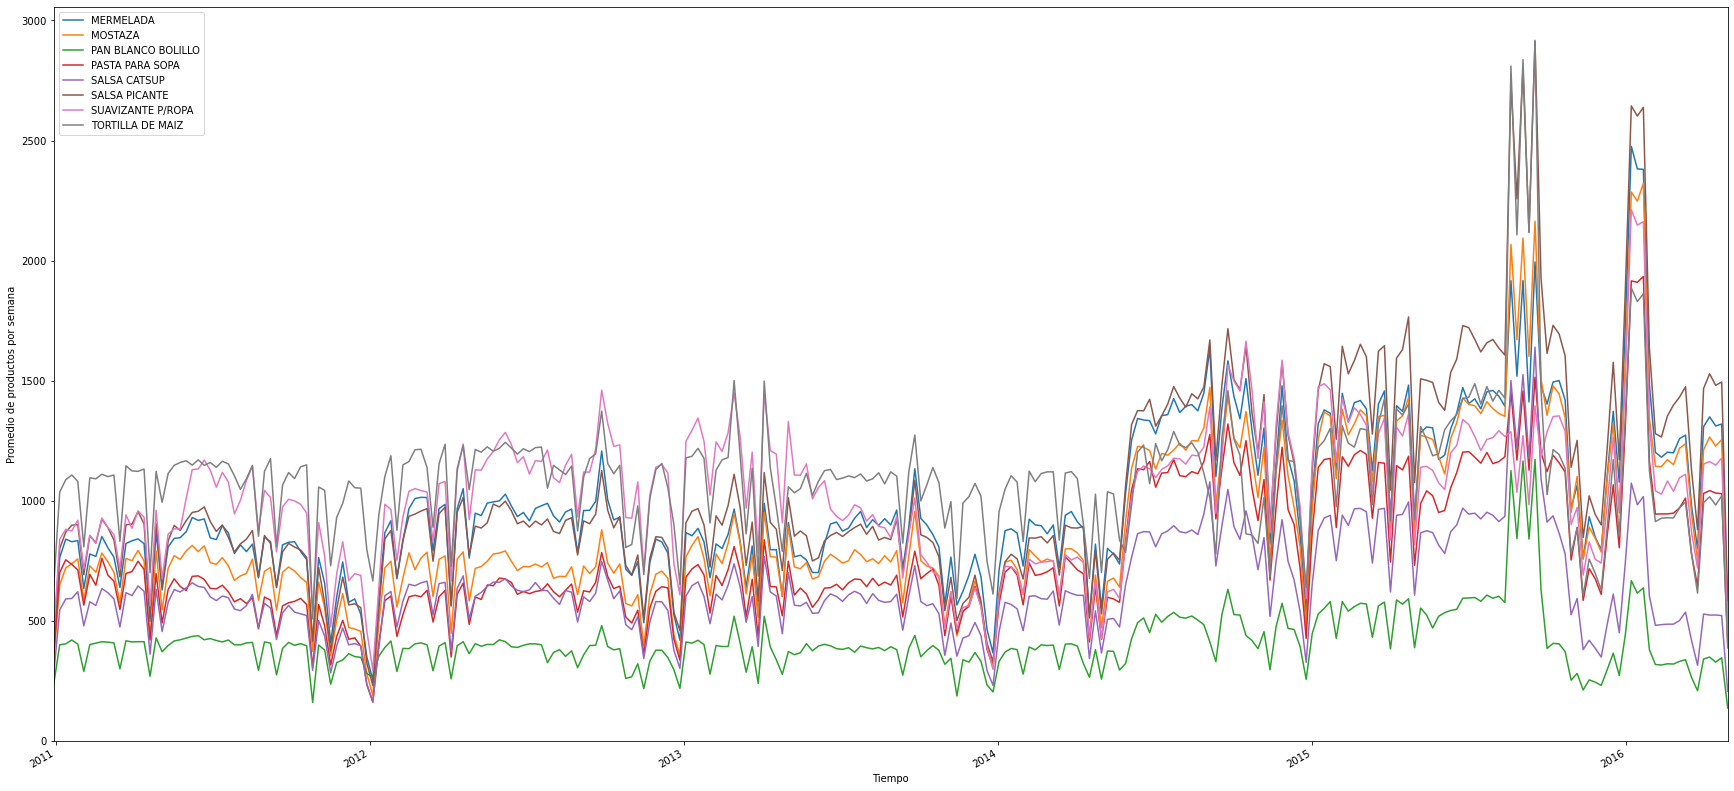

In [51]:
fig, axarr = plt.subplots(1,1,figsize = (30,15))
pdf_prodCanastaST_wide[prodCanasta[16:24]].plot(ax=axarr)
axarr.set_ylabel('Promedio de productos por semana')
axarr.set_xlabel('Tiempo')

### b. ¿Cuál es la ciudad más cara del país? ¿Cuál es la más barata?

El análisis lo realicé por municipios y no por ciudades. El municipio más caro es Hixquilucan, mientras que el más barato es Apodaca.

Para encontrar esta respuesta, simplemente promedié todos los precios de todos los productos de la canasta básica que definí en la pregunta anterior. Hago esta simplificación puesto que en el análisis anterior observé que todos los productos de la canasta tenían un comportamiento "cualitativo" muy parecido. Es decir, si bien podía variar la escala de registros, el comportamiento era muy similar para todos los productos. Entonces, la hipótesis sería que si existen los suficientes registros de la canasta básica para cada municipio, el promedio de sus precios reflejerá que tan cara o barata es la ciudad. Por lo tanto, no tomé en cuenta los municipios que tenían menos de 15 mil registros.

Más abajo se pueden encontrar las tablas que usé para obtener estos resultados.

In [52]:
precios_mun = precios.filter(preciosST['producto'].isin(prodCanasta)).sort('producto', ascending=True).groupBy('municipio', 'producto').agg(avg('precio'))
precios_mun.printSchema()
print('Registros', precios_mun.count())
precios_mun.show(5, truncate=False)

root
 |-- municipio: string (nullable = true)
 |-- producto: string (nullable = true)
 |-- avg(precio): double (nullable = true)

Registros 4558
+----------------------------------------+--------+------------------+
|municipio                               |producto|avg(precio)       |
+----------------------------------------+--------+------------------+
|ATIZAPAN                                |ACEITE  |29.243353322139072|
|BENITO JUAREZ                           |ACEITE  |31.005713811202007|
|IZTACALCO                               |ACEITE  |30.539693877551183|
|NAUCALPAN                               |ACEITE  |31.780660304755457|
|LEON                                    |ACEITE  |30.88471986542051 |
+----------------------------------------+--------+------------------+
only showing top 5 rows



In [53]:
precios_mun = precios.filter(preciosST['producto'].isin(prodCanasta)).groupBy('municipio').agg(avg('precio'),count('producto')).sort(desc('avg(precio)'))
precios_mun.printSchema()
print('Registros', precios_mun.count())


root
 |-- municipio: string (nullable = true)
 |-- avg(precio): double (nullable = true)
 |-- count(producto): long (nullable = false)

Registros 206


In [54]:
precios_mun.show(5, truncate=False)

+----------------------------------------+------------------+---------------+
|municipio                               |avg(precio)       |count(producto)|
+----------------------------------------+------------------+---------------+
|HUIXQUILUCAN                            |19.807156477846313|16047          |
|NOGALES                                 |19.711565717465866|10781          |
|ENSENADA                                |19.663943539477664|42543          |
|MEXICALI                                |19.56261014146956 |53227          |
|NUEVO LAREDO                            |19.477228601819068|46067          |
+----------------------------------------+------------------+---------------+
only showing top 5 rows



In [55]:
precios_mun.toPandas().tail(50)

municipio  avg(precio)  count(producto)
156  GUADALAJARA                                 16.891660           222565
157                               GUADALAJARA    16.881196            64069
158  GUADALUPE                                   16.866396            71850
159  HUAMANTLA                                   16.846380            42372
160                                  ATIZAPÁN    16.788411            23512
161  CENTRO                                      16.781278           152086
162  AGUASCALIENTES                              16.753417            43588
163                                CP. 27280"    16.747841             2089
164                                 TULTITLÁN    16.746751            13406
165  OAXACA DE JUAREZ                            16.712621            81956
166  ATIZAPAN                                    16.684059            67088
167  CARDENAS                                    16.682892            10096
168  SALTILLO                                    16.440456            56410
169  ZACATELCO                                   16.408222            33856
170  BOCA DEL RIO                                16.395216            21811
171                     SANTA CRUZ XOXOCOTLÁN    16.392435             5508
172  CHIAUTEMPAN                                 16.289100            38029
173                                  CÁRDENAS    16.220981            16897
174                                    TOLUCA    16.184840            28965
175                                 HUAMANTLA    16.114204             1068
176  TULTITLAN                                   16.046199            38375
177  SANTA CRUZ XOXOCOTLAN                       15.957164            14970
178  IZTACALCO                                   15.931237            22120
179                                      None    15.875852             2577
180  XOCHIMILCO                                  15.819550            15563
181                               CHIAUTEMPAN    15.683167             1105
182  TOLUCA                                      15.552711            81293
183                                   APODACA    15.545908             5311
184                                 IZTACALCO    15.413676             7872
185                                XOCHIMILCO    15.330694             6442
186  APODACA                                     15.183136            18082
187                                   TLÁHUAC    15.000000              402
188                     CUAJIMALPA DE MORELOS    15.000000              134
189                                MILPA ALTA    15.000000              134
190  MILPA ALTA                                  13.812834              561
191  TLAHUAC                                     13.679775             1691
192  CUAJIMALPA DE MORELOS                       13.565954              561
193                      ATIZAPÁN DE ZARAGOZA    12.191050              343
194                    SANTA LUCIA DEL CAMINO    12.021818              275
195                              ZINACANTEPEC    11.708333              132
196  SANTA LUCIA DEL CAMINO                      11.621656              785
197  ZINACANTEPEC                                11.262976              289
198                          GENERAL ESCOBEDO    11.242243              419
199  ATIZAPAN DE ZARAGOZA                        10.704118              289
200  SAN MATEO ATENCO                            10.700000               10
201  TLAJOMULCO DE ZUÑIGA                        10.613235              272
202  GENERAL ESCOBEDO                            10.204647             1571
203                            SANTA CATARINA    10.033333              315
204  SANTA CATARINA                               9.602234             1410
205                          DISTRITO FEDERAL     1.638636              132

### c. ¿Hay algún patrón estacional entre años?

Del análisis de las series de tiempo correspondientes a los productos de la canasta básica que he propuesto, se puede observar que el registro de productos disminuye en los últimos meses de cada año. Este análisis se encuentra antes en la parte correspondiente al inciso a de esta pregunta, pero enseguida presento una captura de pantalla con el gráfico dónde se observa claramente el efecto estacional descrito.

También, al analizar los precios, cuando hice un análisis de todos los productos (es decir, sin limitar a la canasta básica que propongo), se observaba claramente un aumento de precios estacional (a finales de año). De este análisis adjunto solamente una foto de mi pantalla (mi laptop se bloqueó y tuve que reiniciar todo el análisis desde la carga y limpieza de los datos, lo cual me tomó un tiempo considerable, y cuando volví a hacer esto decidí limitar el análisis a los productos de la canasta básica, por lo tanto no aparece ese análisis en el jupyter notebook).

Sin embargo, al realizar el análisis de precios por estado, pero limitando los productos a la canasta básica que he propuesto, no se alcanza a observar tan claramente la estacionalidad. Si bien este análisis lo realicé con una serie de tiempo con intervalos de 4 semanas (mientras que el análisis con todos los productos lo realicé con un intervalo semanal), este cambio no debería afectar la observación de la estacionalidad. La explicación que encuentro es que los productos elegidos, al ser productos muy básicos, no se ven tan afectados por la estacionalidad observada en el conjunto de todos los productos, la cual segúramente se debe a productos de temporada navideña y a las ventas de promociones de fin de año ("Buen Fin", "Black Friday", etc.). De hecho, esto se corrobora con los valores del eje y (precios promedios), los cuales en el caso de todos los productos son considerablemente más altos que los valores en los productos de la canasta básica propuesta. Es importante recalcar que en el gráfico correspondiente a los productos de la canasta básica, al no observarse una estacionalidad, se ve muy claramente la progresión del aumento de los precios (inflación). 

### Precios promedio de los productos en la canástica básica propuesta

![title](img/2_c.png)

### Precios promedio de TODOS los productos por ESTADO

![title](img/imagen.png)

### Precios promedio de LOS PRODUCTOS EN LA CANÁSTICA BÁSICA PROPUESTA por ESTADO

![title](img/canastaXestado.png)

In [56]:
# Remuestreo
time_group2 = precios.filter(preciosST['producto'].isin(prodCanasta)).groupBy('estado', window('fechaRegistro', '4 week')).agg(avg('precio').alias('PrecioPromedio') )



In [57]:
preciosST2 = time_group2.select('estado', time_group2.window.start.alias('start'), time_group2.window.end.alias('end'), 'PrecioPromedio').orderBy(col('estado').asc(), col('start').asc())


In [58]:
lst_estado = list(sqlPrecios.select('estado').toPandas()['estado'])

In [59]:
lst_estado

['AGUASCALIENTES',
 'BAJA CALIFORNIA',
 'BAJA CALIFORNIA SUR',
 'CAMPECHE',
 'CHIAPAS',
 'CHIHUAHUA',
 'COAHUILA DE ZARAGOZA',
 'COLIMA',
 'DISTRITO FEDERAL',
 'DURANGO',
 'GUANAJUATO',
 'GUERRERO',
 'HIDALGO',
 'JALISCO',
 'MICHOACÁN DE OCAMPO',
 'MORELOS',
 'MÉXICO',
 'NAYARIT',
 'NUEVO LEÓN',
 'OAXACA',
 'PUEBLA',
 'QUERÉTARO',
 'QUINTANA ROO',
 'SAN LUIS POTOSÍ',
 'SINALOA',
 'SONORA',
 'TABASCO',
 'TAMAULIPAS',
 'TLAXCALA',
 'VERACRUZ DE IGNACIO DE LA LLAVE',
 'YUCATÁN',
 'ZACATECAS']

In [60]:
prodCanastaST2 = preciosST2.filter(preciosST2['estado'].isin(lst_estado)).sort('estado','start',ascending=True)


In [61]:
prodCanastaST2_wide = prodCanastaST2.groupBy('start').pivot('estado').agg(avg('PrecioPromedio'))
prodCanastaST2_wide.printSchema()
print('Registros', prodCanastaST2_wide.count())
prodCanastaST2_wide.take(2)


root
 |-- start: timestamp (nullable = true)
 |-- AGUASCALIENTES: double (nullable = true)
 |-- BAJA CALIFORNIA: double (nullable = true)
 |-- BAJA CALIFORNIA SUR: double (nullable = true)
 |-- CAMPECHE: double (nullable = true)
 |-- CHIAPAS: double (nullable = true)
 |-- CHIHUAHUA: double (nullable = true)
 |-- COAHUILA DE ZARAGOZA: double (nullable = true)
 |-- COLIMA: double (nullable = true)
 |-- DISTRITO FEDERAL: double (nullable = true)
 |-- DURANGO: double (nullable = true)
 |-- GUANAJUATO: double (nullable = true)
 |-- GUERRERO: double (nullable = true)
 |-- HIDALGO: double (nullable = true)
 |-- JALISCO: double (nullable = true)
 |-- MICHOACÁN DE OCAMPO: double (nullable = true)
 |-- MORELOS: double (nullable = true)
 |-- MÉXICO: double (nullable = true)
 |-- NAYARIT: double (nullable = true)
 |-- NUEVO LEÓN: double (nullable = true)
 |-- OAXACA: double (nullable = true)
 |-- PUEBLA: double (nullable = true)
 |-- QUERÉTARO: double (nullable = true)
 |-- QUINTANA ROO: double (n

[Row(start=datetime.datetime(2011, 7, 20, 19, 0), AGUASCALIENTES=16.137771894093692, BAJA CALIFORNIA=None, BAJA CALIFORNIA SUR=None, CAMPECHE=None, CHIAPAS=None, CHIHUAHUA=None, COAHUILA DE ZARAGOZA=14.733655536028131, COLIMA=15.970770642201842, DISTRITO FEDERAL=16.89490160823098, DURANGO=None, GUANAJUATO=16.22469972702455, GUERRERO=None, HIDALGO=16.66452631578948, JALISCO=17.235560635750048, MICHOACÁN DE OCAMPO=16.72586031175059, MORELOS=None, MÉXICO=16.585754272641665, NAYARIT=None, NUEVO LEÓN=16.088021836865742, OAXACA=15.464004085801838, PUEBLA=16.16482302080519, QUERÉTARO=16.007693920335434, QUINTANA ROO=16.442867956265776, SAN LUIS POTOSÍ=None, SINALOA=16.687422222222228, SONORA=17.24423076923077, TABASCO=16.164059016393445, TAMAULIPAS=None, TLAXCALA=16.010732368896925, VERACRUZ DE IGNACIO DE LA LLAVE=16.078217194570136, YUCATÁN=16.293638712708475, ZACATECAS=17.236721611721617),
 Row(start=datetime.datetime(2014, 3, 26, 18, 0), AGUASCALIENTES=None, BAJA CALIFORNIA=None, BAJA CALI

In [62]:
pdf_prodCanastaST2_wide = prodCanastaST2_wide.toPandas().set_index('start')
display(pdf_prodCanastaST2_wide.tail())


AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  \
start                                                                       
2012-06-20 19:00:00             NaN              NaN                  NaN   
2014-11-05 18:00:00       17.207756        19.237821            18.734562   
2014-04-23 19:00:00             NaN              NaN                  NaN   
2016-02-24 18:00:00       17.298321        19.777175            19.097044   
2015-07-15 19:00:00       17.554382        19.547837            18.865432   

                      CAMPECHE    CHIAPAS  CHIHUAHUA  COAHUILA DE ZARAGOZA  \
start                                                                        
2012-06-20 19:00:00        NaN        NaN        NaN             17.317433   
2014-11-05 18:00:00  17.763028  17.060937  18.792685             18.160522   
2014-04-23 19:00:00        NaN        NaN        NaN             11.283939   
2016-02-24 18:00:00  18.026689  17.835477  18.999478             17.974581   
2015-07-15 19:00:00  17.920175  17.453163  18.931806             18.363286   

                        COLIMA  DISTRITO FEDERAL    DURANGO  ...  \
start                                                        ...   
2012-06-20 19:00:00  17.957940         18.061403  18.131808  ...   
2014-11-05 18:00:00  17.492571         17.552467  18.163628  ...   
2014-04-23 19:00:00  17.389887         17.816909        NaN  ...   
2016-02-24 18:00:00  18.492776         18.720132  18.897190  ...   
2015-07-15 19:00:00  17.838180         17.922658  18.866162  ...   

                     QUINTANA ROO  SAN LUIS POTOSÍ    SINALOA     SONORA  \
start                                                                      
2012-06-20 19:00:00     17.629593              NaN  18.630143  18.743076   
2014-11-05 18:00:00     17.615656        18.269254  16.827077  18.493636   
2014-04-23 19:00:00     17.580253              NaN  17.721123  18.269203   
2016-02-24 18:00:00     18.337962        19.215496  19.477173  19.604285   
2015-07-15 19:00:00     17.586650        18.116108  18.161108  19.051025   

                       TABASCO  TAMAULIPAS   TLAXCALA  \
start                                                   
2012-06-20 19:00:00  16.910829         NaN  17.272769   
2014-11-05 18:00:00  17.113577   18.809553  16.942851   
2014-04-23 19:00:00  17.087690         NaN  16.765760   
2016-02-24 18:00:00  18.008297   18.768213  17.907497   
2015-07-15 19:00:00  17.147055   18.629898  17.661391   

                     VERACRUZ DE IGNACIO DE LA LLAVE    YUCATÁN  ZACATECAS  
start                                                                       
2012-06-20 19:00:00                        17.949416  17.379963  18.124044  
2014-11-05 18:00:00                        17.025483  17.301210  17.312280  
2014-04-23 19:00:00                              NaN  17.818025  17.573870  
2016-02-24 18:00:00                        18.090163  18.646587  18.219449  
2015-07-15 19:00:00                        17.812068  17.623871  18.082347  

[5 rows x 32 columns]

Text(0.5, 0, 'Tiempo')

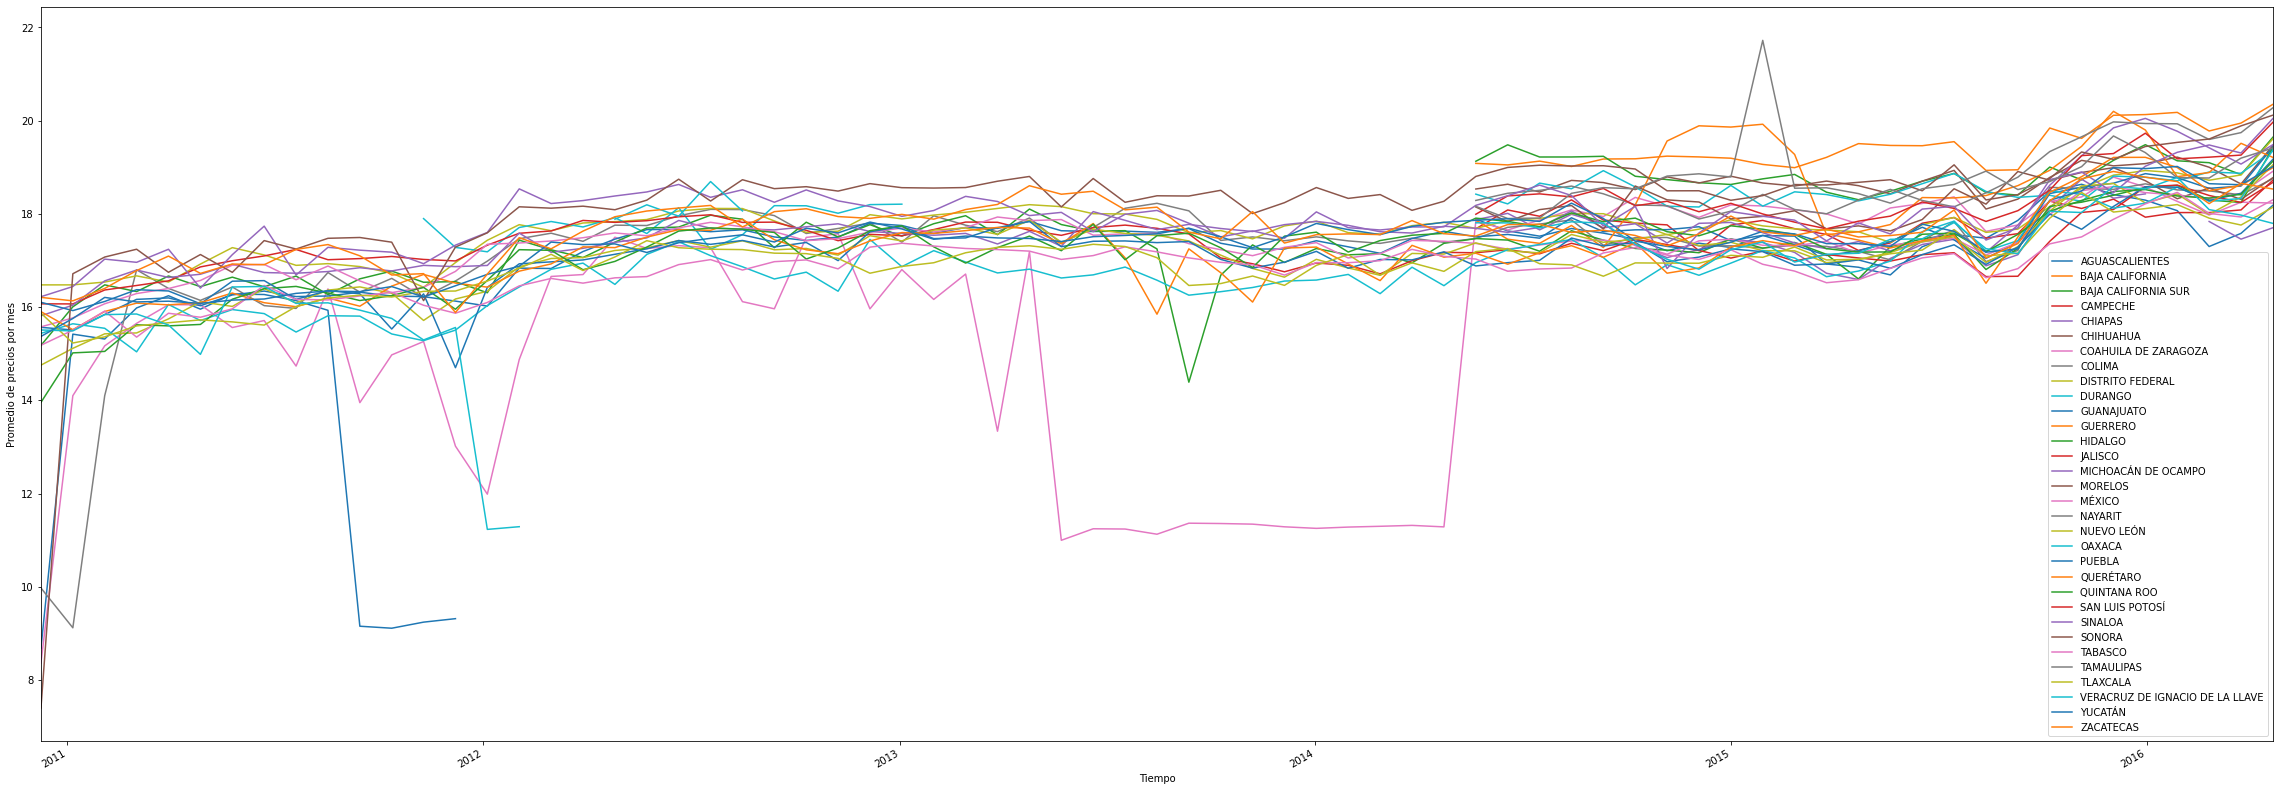

In [63]:
fig, axarr = plt.subplots(1,1,figsize = (40,15))
pdf_prodCanastaST2_wide[lst_estado].plot(ax=axarr)
axarr.set_ylabel('Promedio de precios por mes')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

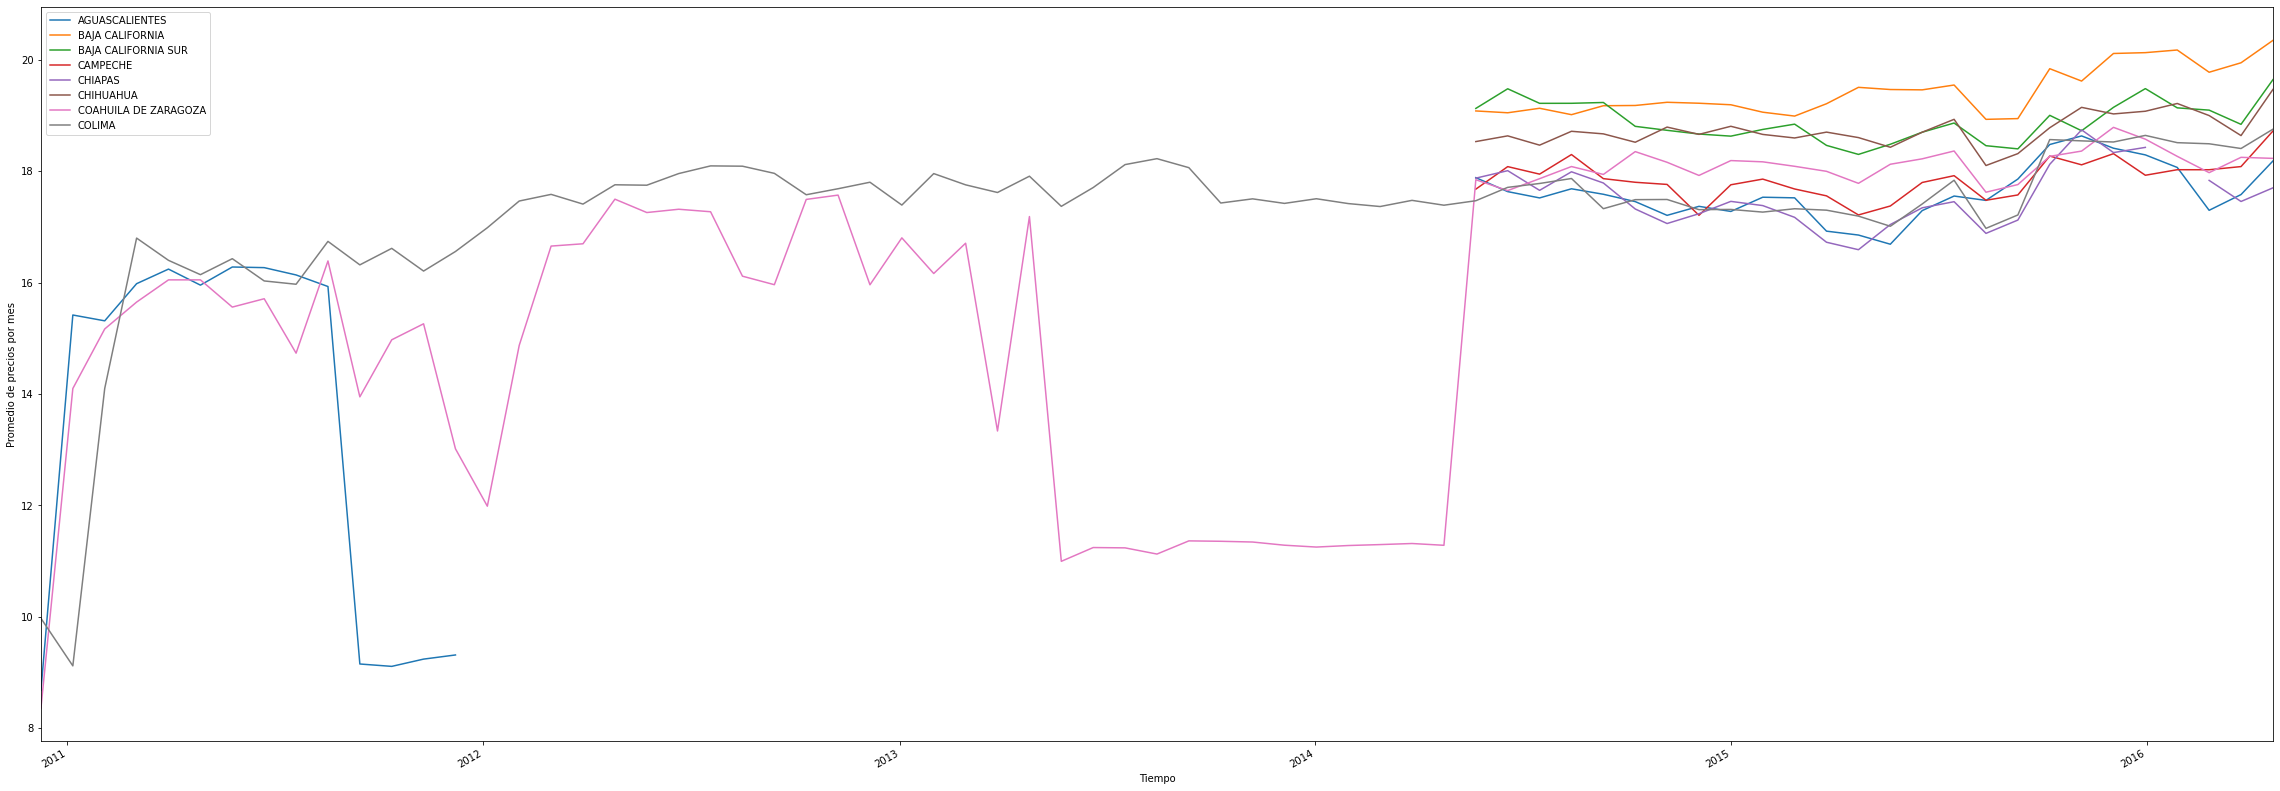

In [68]:
fig, axarr = plt.subplots(1,1,figsize = (40,15))
pdf_prodCanastaST2_wide[lst_estado[0:8]].plot(ax=axarr)
axarr.set_ylabel('Promedio de precios por mes')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

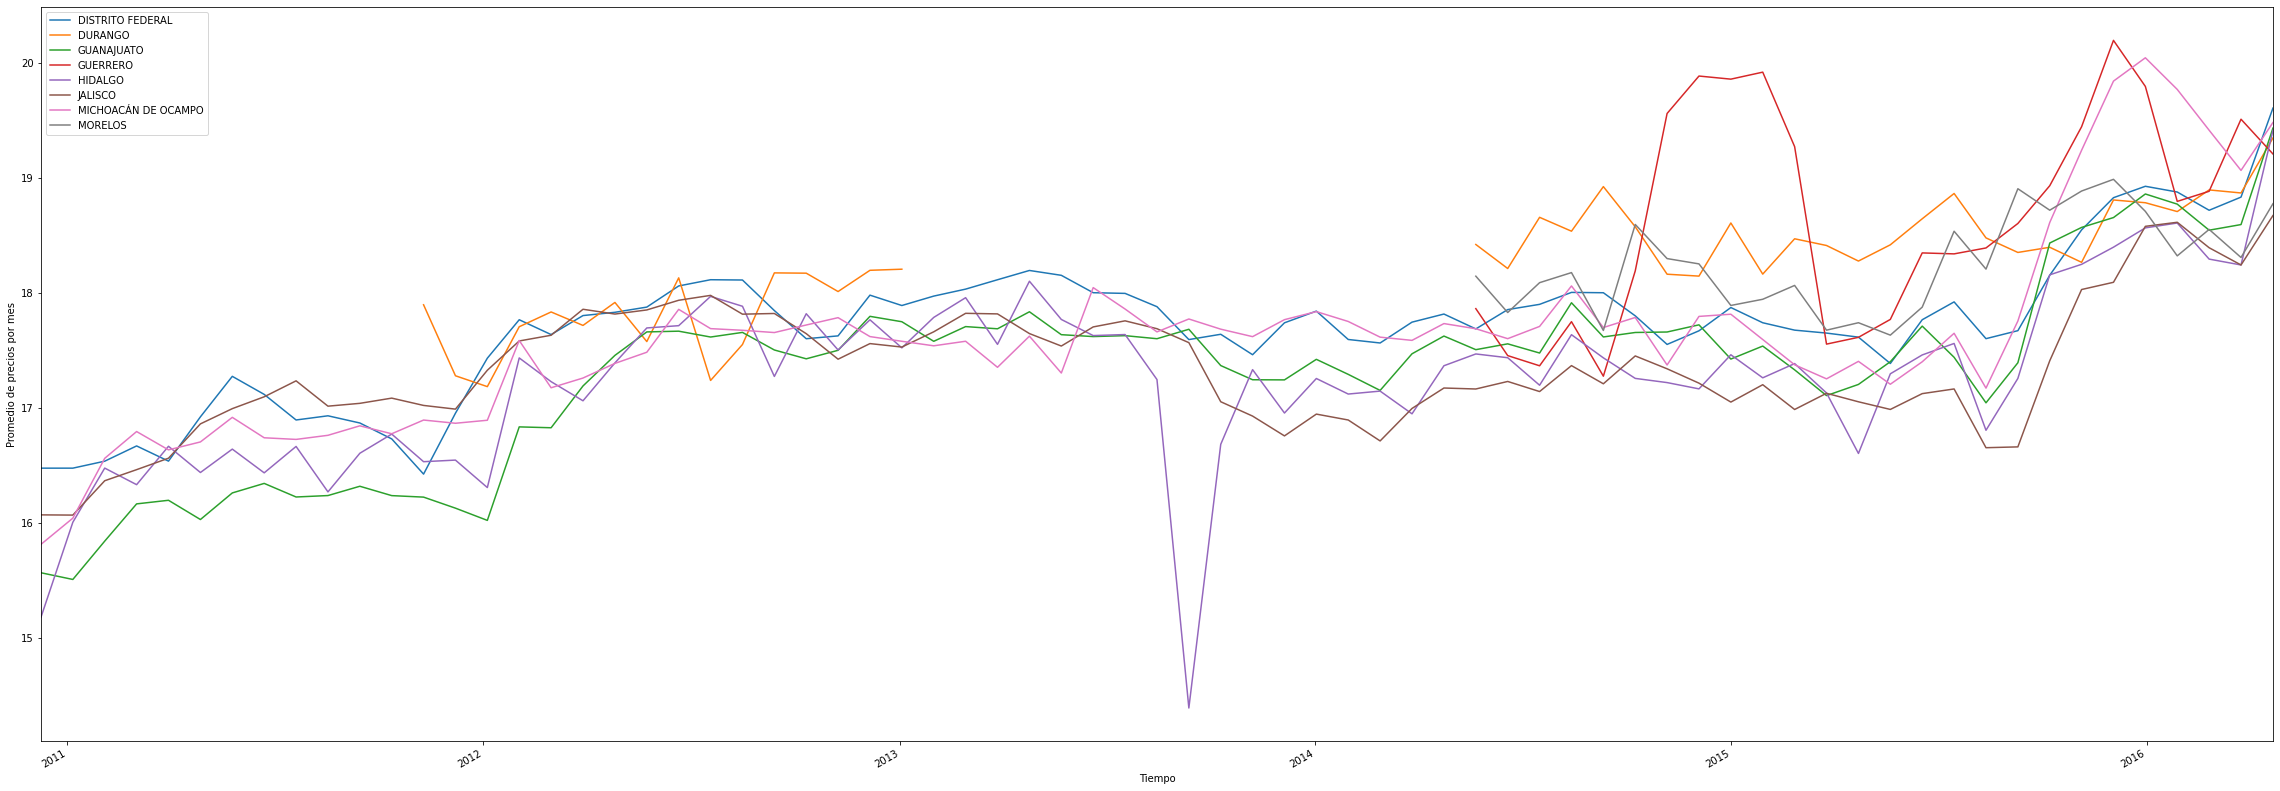

In [69]:
fig, axarr = plt.subplots(1,1,figsize = (40,15))
pdf_prodCanastaST2_wide[lst_estado[8:16]].plot(ax=axarr)
axarr.set_ylabel('Promedio de precios por mes')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

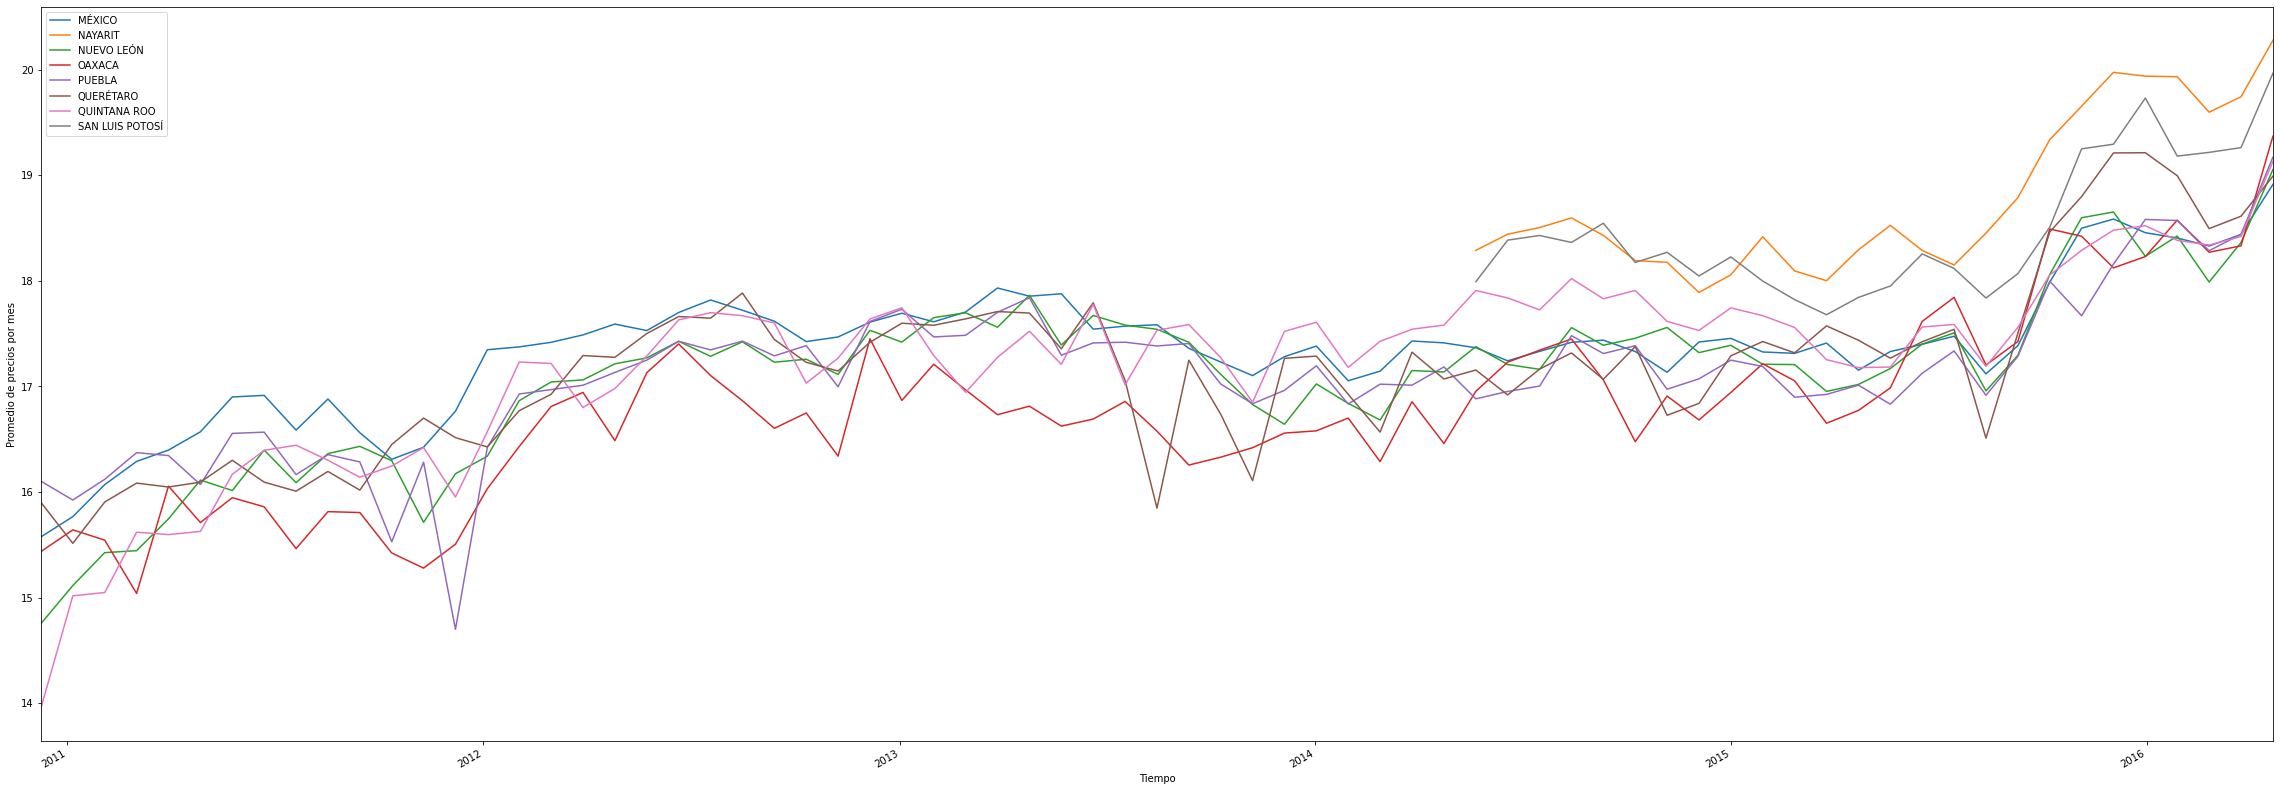

In [70]:
fig, axarr = plt.subplots(1,1,figsize = (40,15))
pdf_prodCanastaST2_wide[lst_estado[16:24]].plot(ax=axarr)
axarr.set_ylabel('Promedio de precios por mes')
axarr.set_xlabel('Tiempo')

Text(0.5, 0, 'Tiempo')

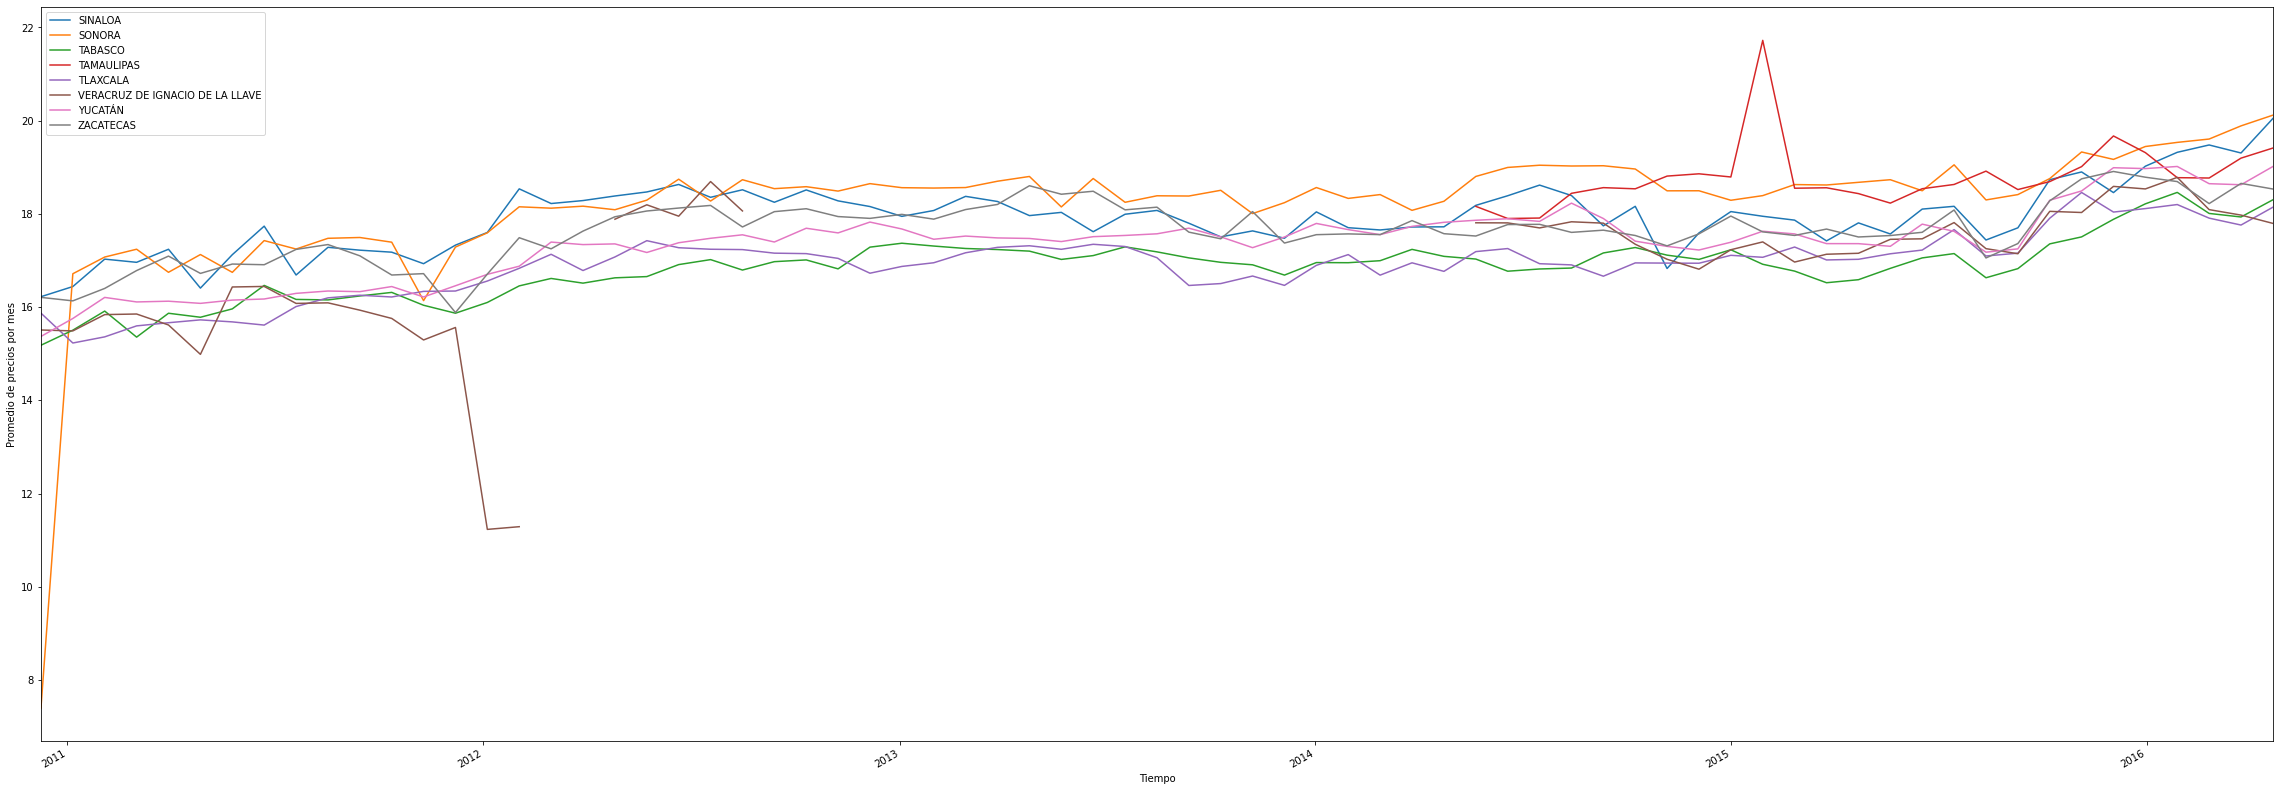

In [71]:
fig, axarr = plt.subplots(1,1,figsize = (40,15))
pdf_prodCanastaST2_wide[lst_estado[24:]].plot(ax=axarr)
axarr.set_ylabel('Promedio de precios por mes')
axarr.set_xlabel('Tiempo')

### d. ¿Cuál es el estado más caro y en qué mes?

En los datos correspondientes a la canasta básica propuesta en este trabajo, se observa un pico interesante para TAMAULIPAS en FEBRERO DE 2015. Tambíen se puede ver un aumento considerable para GUERRERP entre FINALES DEL 2015 Y PRINCIPIOS DEL 2014. Habría que hacer un análisis más detallado para descartar que se trate de errores en los datos. EStos resultados no me parecen muy intuitivos, pues esperaría que los estados con grandes concentraciones urbanas (CDMX, Nuevo Léon, Jalisco, etc.) fuesen los estados más caros. Sin embargo, al entender que este análisis se realizó tomando productos muy básicos que están presentes en todos los estados, puedo generar una hipótesis que me parece interesante: la variación de precio en los productos básicos no es tan importante a través de los estados mexicanos, y de hecho lo que haría a otros estados ser "los más caros", sería el consumo de productos que estarían fuera de una canasta básica. Esta hipótesis sería válida si y solo sí me aseguro que el comportamiento que observé no se debe a un problema en mis datos (outliers o errores), o bien a un sesgo que haya introducido en una mala elección de los productos que integran la canasta básica que he propuesto. 

Por otro lado, si supongo que los valores antes mencionado de Tamaulipas y Guerrero son valores atípicos/erróneos, el estado más caro que podría observar sería Baja California, seguido muy de cerca de Nayarit, en los cuales se presentaría su pico en el mes de Abril del 2016, respuesta que debe tomarse con cuidado tomando en cuenta las consideraciones antes mencionadas (sobre todo la aparente "no estacionalidad" de los datos correspondientes a la canasta básica propuesta).

De la gráficas de los precios a partir de todos los productos (que perdí y solo tengo una foto de la pantalla), se observa un pico en enero de 2016, pero desgraciadamente no alcanzo a distinguir el estado al cual corresponde este resultado.

### e. ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con estos datos?

El principal problema que veo con estos datos es la "uniformidad" de los productos que se comparan. Es decir, cuando se analiza algún producto, no necesariamente se están comparando los mismos productos en las mismas presentaciones. Por ejemplo, dentro del producto "mayonesa" habrá presentaciones con distintos presentaciones (distintos pesos) o subtipos de mayonesas (ligth o regular). En mi intento de propuesta de canasta básica, intenté atenuar este efecto a partir de la elección de productos que tienen más muestras (registros). La alternativa sería realizar un análisis detallado de los productos elegidos, y asegurarse que se comparen (u otra opción sería encontrar una manera de ponderar la representatividad de cada "subtipo" producto) productos equivalentes. Esto, a una escala nacional, creo que sería complicado hacerlo y más bien podría darse esta escala de detalle en un análisis específico de municipios/ciudades particulares.

Otro problema que se hizo evidente en los últimos gráficos, es la calidad de los datos. Se observan faltantes en varios estados. Se tendría que analizar la causa de estos faltantes: ¿No se capturaba información en esos lapsos? ¿O hubo un problema de formato que ocasionó que estos datos se eliminaran en la limpieza hecha a estos datos (limpieza muy sencilla dónde solo eliminé registros a partir de faltantes en algunas columnas)? 

También he observado que en el gráfico de todos los productos por estado (el que perdí), hay estados que tienen información al principio, y después ya no. Esto puede deberse a que los productos que se registran en estos lapsos faltantes, pueden estár registrados con "errores" o diferencias que hacen que no se tomen en cuenta en este análisis. Esto tendría que descartarse en un análisis más detallado.

## 3. Visualización

### a. Genera un mapa que nos permita identificar la oferta de categorías en la zona metropolitana de León Guanajuato y el nivel de precios en cada una de ellas. Se darán puntos extra si el mapa es interactivo.

Para esta pregunta, lo que pensaba hacer es presentar un mapa similar a los que presenté en la sección A. Ya no me dió tiempo de realizarlo, pero los pasos serían:

* Restringir los datos a la zona metropolitana de León Guanajuato (a partir de restringir los datos en función de los municipios que abarca la zona urbana, o bien a partir de un polígono de la zona urbana y las coordenadas en los datos de PROFECO)
* Agrupar y agregar la información con los criterios requeridos (maximos, minimos, etc.)
* Generar el mapa interactivo (como los que presenté en la sección A)

In [64]:
#spark.stop()